## Data Source / Following Along

https://archive.org/details/stackexchange

https://github.com/data-skeptic/feature-engineering-training

https://s3.amazonaws.com/dataskeptic-static/farcon/Badges.xml

# Loading our data to a dataframe

In [161]:
%matplotlib inline
import matplotlib.pyplot as plt
import xmltodict
import pandas as pd
import datetime
import bleach
import math
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from scipy.stats.stats import pearsonr

In [162]:
fname = 'stats.stackexchange.com/Posts.xml'

In [163]:
import xml.etree.ElementTree
e = xml.etree.ElementTree.parse('stats.stackexchange.com/Posts.xml').getroot()

In [164]:
document_file = open(fname, "r")
original_doc = document_file.read()
document = xmltodict.parse(original_doc)

In [165]:
df = pd.DataFrame(document['posts']['row'])

In [166]:
df.columns = list(map(lambda x: x.replace('@', ''), df.columns))

In [167]:
pd.options.display.max_columns = 999

In [168]:
df.head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,LastEditorUserId,LastEditDate,CommunityOwnedDate,ParentId,ClosedDate,OwnerDisplayName,LastEditorDisplayName
0,1,1,15,2010-07-19T19:12:12.510,36,2475,<p>How should I elicit prior distributions fro...,8,2010-09-15T21:08:26.077,Eliciting priors from experts,<bayesian><prior><elicitation>,5,1,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,59,2010-07-19T19:12:57.157,29,22817,<p>In many different statistical methods there...,24,2016-06-27T06:44:40.147,What is normality?,<distributions><normality>,7,1,10,88,2010-08-07T17:56:44.800,NaN,NaN,NaN,NaN,NaN
2,3,1,5,2010-07-19T19:13:28.577,66,5746,<p>What are some valuable Statistical Analysis...,18,2013-05-27T14:48:36.927,What are some valuable Statistical Analysis op...,<software><open-source>,19,4,39,183,2011-02-12T05:50:03.667,2010-07-19T19:13:28.577,NaN,NaN,NaN,NaN
3,4,1,135,2010-07-19T19:13:31.617,17,25380,<p>I have two groups of data. Each with a dif...,23,2010-09-08T03:00:19.690,Assessing the significance of differences in d...,<distributions><statistical-significance>,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2,NaN,2010-07-19T19:14:43.050,86,NaN,"<p>The R-project</p>\n\n<p><a href=""http://www...",23,2010-07-19T19:21:15.063,NaN,NaN,NaN,3,NaN,23,2010-07-19T19:21:15.063,2010-07-19T19:14:43.050,3,NaN,NaN,NaN


## Data Cleaning

In [169]:
df['ViewCount'].fillna(0, inplace=True)
df['ViewCount'] = df['ViewCount'].astype(int)
df['Score'] = df['Score'].astype(int)
df['CreationDate'] = pd.to_datetime(df['CreationDate'])

In [170]:
df.groupby(['PostTypeId'])['ViewCount'].median()

PostTypeId
1    131
2      0
3      0
4      0
5      0
6      0
7      0
Name: ViewCount, dtype: int64

This field seems useless, let's get rid of it

In [171]:
del df['PostTypeId']

## Understanding Our Objective
We should expect that our result can be highly biased by right censorship.

In [174]:
df['cdt'] = df['CreationDate'].apply(lambda x: datetime.datetime.date(x))

In [177]:
g = pd.DataFrame(df.groupby(['cdt'])['ViewCount'].mean())
g.reset_index(inplace=True)
g.sort_values('cdt', inplace=True)

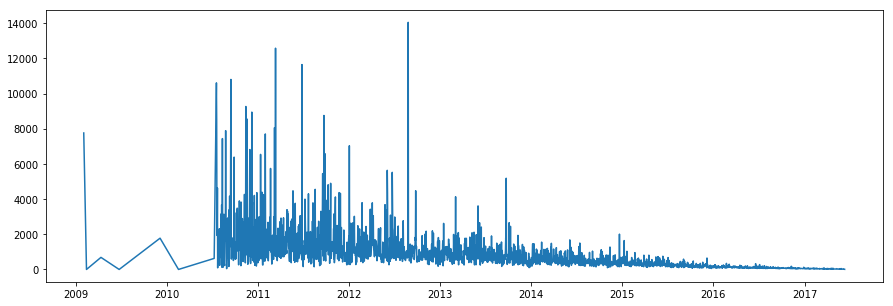

In [182]:
plt.figure(figsize=(15,5))
plt.plot(g['cdt'], g['ViewCount'])
plt.show()

In [183]:
g = pd.DataFrame(df.groupby(['ViewCount'])['Id'].count())
g.reset_index(inplace=True)
g['ViewCount'] = g['ViewCount'].astype(int)
g.sort_values('ViewCount', inplace=True)
g.columns = ['ViewCount', 'frequency']

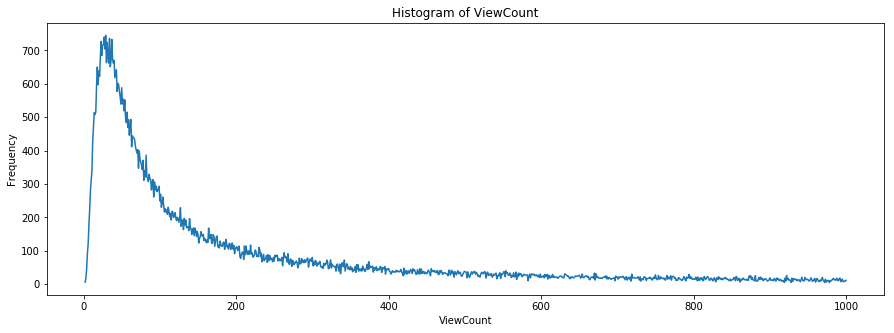

In [185]:
plt.figure(figsize=(15,5))
plt.plot(g['ViewCount'][1:1000], g['frequency'][1:1000])
plt.ylabel('Frequency')
plt.xlabel('ViewCount')
plt.title('Histogram of ViewCount')
plt.show()

In [186]:
del df['cdt']

What's up with the "score"?

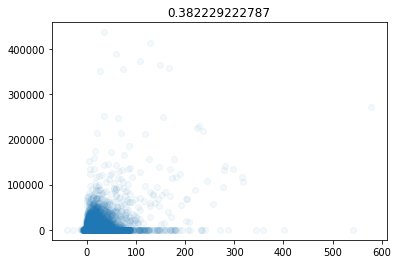

In [173]:
r2 = pearsonr(df['Score'], df['ViewCount'])[0]
plt.scatter(df['Score'], df['ViewCount'], alpha=0.05)
plt.title(r2)
plt.show()

## Remove possible Leakage Features
Let's be specific about what we want to predict.  Since our data is a snapshot in time, we can't predice "ViewCountTomorrow".  We should therefore predict given the merits of the question itself at the time of creation.

In [193]:
leakage_features = [
'Id','FavoriteCount','AnswerCount','CommentCount','AcceptedAnswerId'
,'LastEditDate','CommunityOwnedDate','ParentId','ClosedDate','LastEditorDisplayName'
,'LastActivityDate','LastEditorUserId','Score']

In [188]:
for lf in leakage_features:
    del df[lf]

## Tags

In [194]:
df['Tags'].head()

0               <bayesian><prior><elicitation>
1                   <distributions><normality>
2                      <software><open-source>
3    <distributions><statistical-significance>
4                                             
Name: Tags, dtype: object

In [189]:
df['Tags'].fillna('', inplace=True)

How many types of Tags are there?

In [195]:
def tag2arr(s):
    if len(s) < 2:
        return []
    s = s[1:-1]
    arr = s.split('><')
    return arr

tags = df['Tags'].apply(tag2arr)

alltags = []
for arr in tags:
    alltags.extend(arr)

len(set(alltags))

1330

Let's make one quick feature from the metadata

In [200]:
df['tag_count'] = tags.apply(lambda x: len(x))

*What is the distribution of usage over these tags?*

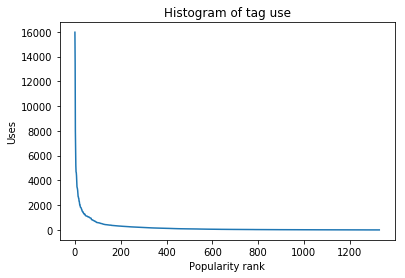

In [219]:
dfx = pd.DataFrame(pd.Series(alltags), columns=['tag'])
dfx['c'] = 1
g = pd.DataFrame(dfx.groupby(['tag'])['c'].sum())
g.reset_index(inplace=True)
g.sort_values('c', ascending=False, inplace=True)
g.index = np.arange(g.shape[0])
plt.plot(g['c'])
plt.title('Histogram of tag use')
plt.xlabel('Popularity rank')
plt.ylabel('Uses')
plt.show()

*Can we focus on just the popular ones and lump the long tail into "Other"?*

In [208]:
df['first_tag'] = tags.apply(lambda x: '' if len(x) == 0 else x[0])
ft = df.groupby(['first_tag']).aggregate({'ViewCount': np.median, 'Title': len})

In [209]:
ft.columns = ['uses', 'MedianViewCount']

In [210]:
dfx = ft[ft['uses'] > 20].copy()

In [211]:
dfx.sort_values('MedianViewCount', inplace=True)
dfx.reset_index(inplace=True)

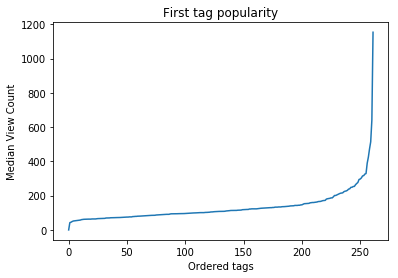

In [212]:
plt.plot(dfx['MedianViewCount'])
plt.xlabel('Ordered tags')
plt.ylabel('Median View Count')
plt.title('First tag popularity')
plt.show()

In [213]:
dfx.tail(20)

,first_tag,uses,MedianViewCount
242,effect-size,60,248.5
243,kolmogorov-smirnov,44,249.0
244,k-means,54,253.5
245,psychometrics,47,254.0
246,r,15943,264.0
247,ridge-regression,22,271.0
248,contingency-tables,34,277.0
249,scales,54,294.5
250,large-data,21,297.0
251,stata,296,303.5


In [214]:
dfx.sort_values('uses', inplace=True, ascending=False)
dfx.head(20)

,first_tag,uses,MedianViewCount
0,,102750,0.0
246,r,15943,264.0
162,regression,10981,124.0
178,machine-learning,6595,133.0
118,probability,4575,102.0
179,time-series,4553,133.0
117,hypothesis-testing,3599,102.0
166,distributions,2783,127.0
76,self-study,2610,87.5
169,correlation,2090,129.0


No tags == no views!

In [215]:
df[df['first_tag']=='']['ViewCount'].max()

0

Let's make a simple metadata feature

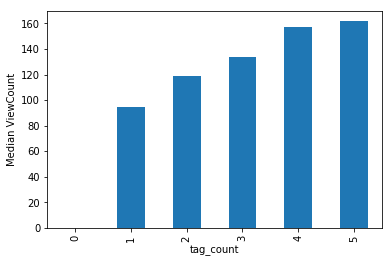

In [216]:
df.groupby(['tag_count'])['ViewCount'].median().plot(kind='bar')
plt.ylabel('Median ViewCount')
plt.show()

In [217]:
tc_dummies = pd.get_dummies(df['tag_count'])
tc_dummies.columns = list(map(lambda x: 'tc_' + str(x), tc_dummies.columns))
df = pd.concat([df, tc_dummies], axis=1)

In [218]:
del df['tag_count']

There's more to be done with tags, but let's move along and possibly come back to it.

## Handling long tailed categorical data

In [ ]:
convert top 20 of first_tag

In [ ]:
PCA?

## Textual meta-data

In [ ]:
df['title_len'] = df['Title'].apply(lambda x: len(str(x)))
df['body_len'] = df['Body'].apply(lambda x: len(str(x)))

In [ ]:
plt.scatter(df['body_len'], df['ViewCount'], alpha=0.05)
plt.show()

In [54]:
df['Body2'] = df['Body'].apply(lambda x: bleach.clean(x, tags=[], attributes={}, styles=[], strip=True))

In [75]:
for bod in df['Body2'][0:10]:
    print(bod)
    print('------------------------------')

How should I elicit prior distributions from experts when fitting a Bayesian model?

------------------------------
In many different statistical methods there is an "assumption of normality".  What is "normality" and how do I know if there is normality?

------------------------------
What are some valuable Statistical Analysis open source projects available right now?

Edit: as pointed out by Sharpie, valuable could mean helping you get things done faster or more cheaply.

------------------------------
I have two groups of data.  Each with a different distribution of multiple variables.  I'm trying to determine if these two groups' distributions are different in a statistically significant way.  I have the data in both raw form and binned up in easier to deal with discrete categories with frequency counts in each.  

What tests/procedures/methods should I use to determine whether or not these two groups are significantly different and how do I do that in SAS or R (or Orange)?

-----

## Audience question: Should we really be focusing on the Body?  Any problems with this strategy?

In [80]:
def substringCount(haystack, needle):
    c = 0
    haystack = haystack.strip()
    i = 0
    while i != -1:
        i = haystack.find(needle, i+1)
        if i != -1:
            c += 1
    return c

In [86]:
df['body_newline_count'] = df['Body2'].apply(lambda x: substringCount(x, '\n'))

In [88]:
df['body_newline_count'] = df['body_newline_count'].apply(lambda x: math.log(x+1))

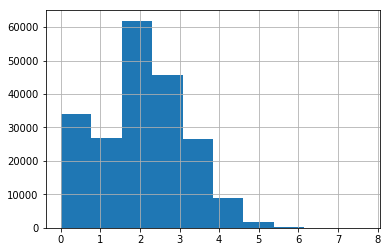

In [89]:
df['body_newline_count'].hist()

In [68]:
df['amt_html'] = 1.0 - df['Body2'].apply(len) / df['Body'].apply(len)

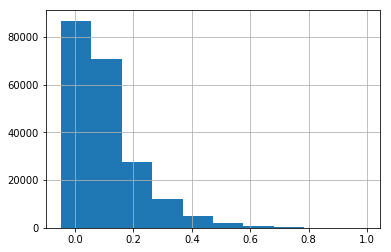

In [69]:
df['amt_html'].hist()
plt.show()

In [70]:
df['amt_html'] = df['amt_html'].apply(lambda x: math.log(x+1))

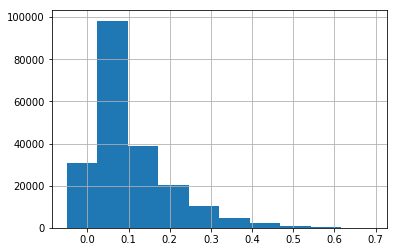

In [71]:
df['amt_html'].hist()
plt.show()

In [72]:
df['has_link'] = df['Body2'].apply(lambda x: x.find('http:') > 0 or x.find('https:') > 0)

In [73]:
df.groupby(['has_link'])['Body2'].count()

has_link
False    192844
True      13472
Name: Body2, dtype: int64

In [59]:
df.head()

,ViewCount,Body,OwnerUserId,Title,Tags,OwnerDisplayName,first_tag,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,days_since,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,hod_0,hod_1,hod_2,hod_3,hod_4,hod_5,hod_6,hod_7,hod_8,hod_9,hod_10,hod_11,hod_12,hod_13,hod_14,hod_15,hod_16,hod_17,hod_18,hod_19,hod_20,hod_21,hod_22,hod_23,Body2,amt_html
0,2475,<p>How should I elicit prior distributions fro...,8,Eliciting priors from experts,<bayesian><prior><elicitation>,NaN,bayesian,0,0,0,1,0,0,2518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,How should I elicit prior distributions from e...,0.076923
1,22817,<p>In many different statistical methods there...,24,What is normality?,<distributions><normality>,NaN,distributions,0,0,1,0,0,0,2518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,In many different statistical methods there is...,0.047945
2,5746,<p>What are some valuable Statistical Analysis...,18,What are some valuable Statistical Analysis op...,<software><open-source>,NaN,software,0,0,1,0,0,0,2518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,What are some valuable Statistical Analysis op...,0.067961
3,25380,<p>I have two groups of data. Each with a dif...,23,Assessing the significance of differences in d...,<distributions><statistical-significance>,NaN,distributions,0,0,1,0,0,0,2518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,I have two groups of data. Each with a differ...,0.028169
4,0,"<p>The R-project</p>\n\n<p><a href=""http://www...",23,NaN,,NaN,,1,0,0,0,0,0,2518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,The R-project\n\nhttp://www.r-project.org/\n\n...,0.395872


In [55]:
df[['Body', 'Body2']].head()

,Body,Body2
0,<p>How should I elicit prior distributions fro...,How should I elicit prior distributions from e...
1,<p>In many different statistical methods there...,In many different statistical methods there is...
2,<p>What are some valuable Statistical Analysis...,What are some valuable Statistical Analysis op...
3,<p>I have two groups of data. Each with a dif...,I have two groups of data. Each with a differ...
4,"<p>The R-project</p>\n\n<p><a href=""http://www...",The R-project\n\nhttp://www.r-project.org/\n\n...


In [ ]:
has_latex

## Time features

In [36]:
df['hod'] = df['CreationDate'].apply(lambda x: x.hour)

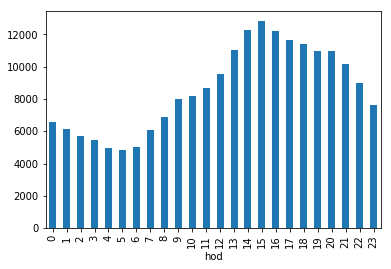

In [37]:
df.groupby(['hod'])['CreationDate'].count().plot(kind='bar')
plt.show()

In [38]:
df['dow'] = df['CreationDate'].apply(lambda x: x.dayofweek)

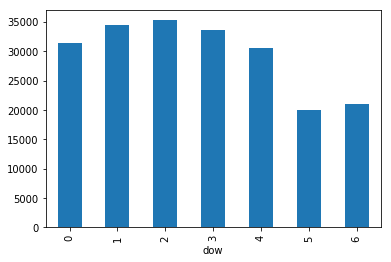

In [39]:
df.groupby(['dow'])['CreationDate'].count().plot(kind='bar')
plt.show()

In [40]:
df['m'] = df['CreationDate'].apply(lambda x: x.month)

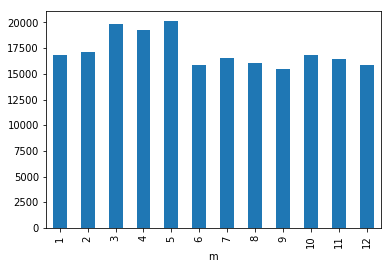

In [41]:
df.groupby(['m'])['CreationDate'].count().plot(kind='bar')
plt.show()

In [42]:
last = df['CreationDate'].max()

In [43]:
df['days_since'] = (last - df['CreationDate']).apply(lambda x: x.days)

In [ ]:
days_since

In [44]:
tc_dummies = pd.get_dummies(df['dow'])
tc_dummies.columns = list(map(lambda x: 'dow_' + str(x), tc_dummies.columns))
df = pd.concat([df, tc_dummies], axis=1)

In [45]:
tc_dummies = pd.get_dummies(df['hod'])
tc_dummies.columns = list(map(lambda x: 'hod_' + str(x), tc_dummies.columns))
df = pd.concat([df, tc_dummies], axis=1)

In [46]:
del df['CreationDate']
del df['dow']
del df['hod']
del df['m']

## Crude User Modeling

In [100]:
g = pd.DataFrame(df.groupby(['OwnerUserId'])['Body'].count())
g.sort_values('Body', ascending=False, inplace=True)
g.reset_index(inplace=True)
g.head()

,OwnerUserId,Body
0,805,3893
1,686,2026
2,919,1873
3,7290,1556
4,11032,1121


In [102]:
len(set(df['OwnerDisplayName']))

2919

In [108]:
list(set(df['OwnerDisplayName']))[0:100]

[nan,
 'HBriz',
 'sjcockell',
 'user3656',
 'Marc Shivers',
 'aaaaa',
 'AF7',
 'BKS',
 'Dawny33',
 'richardh',
 'Faheem Mitha',
 'smci',
 'Rishi Bhatt',
 'Tzippy',
 'user3288',
 'Mahin',
 'Harminder Puri',
 'user2498193',
 'egens',
 'Matt SM',
 'matteo',
 'David',
 'Sik',
 'Aby Mathew',
 'noli macnoli',
 'user3444294',
 'iratzhash',
 'Jørgen K. Kanters',
 'user3437823',
 'Guy',
 'Gavin Senior',
 'Henry David Thorough',
 'user2975626',
 'user1868569',
 'jasonweiyi',
 'Jas Sutton',
 'Alexander Fokas',
 'Luke404',
 'psbookmark',
 'Gaurav Chaturvedi',
 'Oleg',
 'user21146',
 'user3154',
 'Kroll DU',
 'user3507',
 'Docconcoct',
 'user3585509',
 'user3233',
 'user25574',
 'Sasha Prokuda',
 'Felixyz',
 'user3096833',
 'learner',
 'niko',
 'PepsiCo',
 'adrian1121',
 'DonAndre',
 'Lepidopterist',
 'Barker',
 'user28597',
 'meryll',
 'Kazem',
 'Sarang',
 'user3666',
 'agstudy',
 'Werner',
 'Jake',
 'Mash',
 'piravi',
 'BLR',
 'Hashtag',
 'user3233557',
 'Joel Lafond Lapalme',
 'Christof',
 'Matt

In [ ]:
missing, userNNNNN, other

## External Data

In [ ]:
Google NLP service for Persons

## Natural Language Processing

In [ ]:
Title

In [111]:
df.head()

,ViewCount,Tags,first_tag,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,days_since,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,hod_0,hod_1,hod_2,hod_3,hod_4,hod_5,hod_6,hod_7,hod_8,hod_9,hod_10,hod_11,hod_12,hod_13,hod_14,hod_15,hod_16,hod_17,hod_18,hod_19,hod_20,hod_21,hod_22,hod_23,amt_html,has_link,body_newline_count
0,2475,<bayesian><prior><elicitation>,bayesian,0,0,0,1,0,0,2518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.074108,False,0.000000
1,22817,<distributions><normality>,distributions,0,0,1,0,0,0,2518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.046831,False,0.000000
2,5746,<software><open-source>,software,0,0,1,0,0,0,2518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.065751,False,1.098612
3,25380,<distributions><statistical-significance>,distributions,0,0,1,0,0,0,2518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.027780,False,1.098612
4,0,,,1,0,0,0,0,0,2518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.333520,True,2.197225


In [ ]:
PCA

In [113]:
del df['Title']
del df['OwnerDisplayName']
del df['Body']
del df['Body2']
del df['OwnerUserId']
del df['Tags']
del df['first_tag']

In [ ]:
del df['Id']
del df['OwnerUserId']

# Further work
More tag based features

## Model Building and Evaluation

In [115]:
kf = KFold(n_splits=5, random_state=None, shuffle=False)

In [117]:
features = df.columns.tolist()

In [127]:
features.remove('ViewCount')

In [128]:
print(features)

['tc_0', 'tc_1', 'tc_2', 'tc_3', 'tc_4', 'tc_5', 'days_since', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'hod_0', 'hod_1', 'hod_2', 'hod_3', 'hod_4', 'hod_5', 'hod_6', 'hod_7', 'hod_8', 'hod_9', 'hod_10', 'hod_11', 'hod_12', 'hod_13', 'hod_14', 'hod_15', 'hod_16', 'hod_17', 'hod_18', 'hod_19', 'hod_20', 'hod_21', 'hod_22', 'hod_23', 'amt_html', 'has_link', 'body_newline_count']


In [129]:
df = df.fillna(0)

In [130]:
X = df[features]
y = df['ViewCount']

In [135]:
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

In [141]:
err = pd.Series((y_test - preds) ** 2)

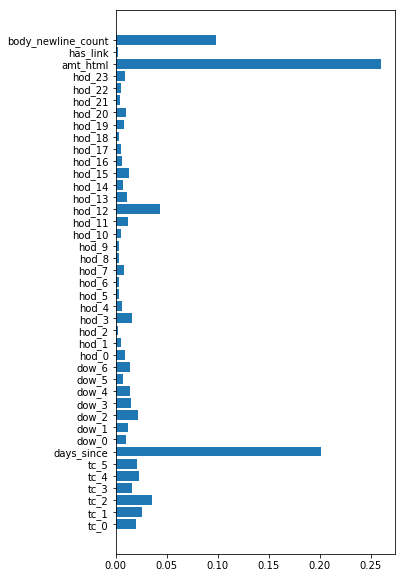

In [158]:
fi = rf.feature_importances_
x = np.arange(len(fi))
plt.figure(figsize=(5,10))
plt.barh(x, fi)
plt.yticks(x,features)
plt.show()

In [145]:
pearsonr(y_test, preds)

(0.094912012988646779, 3.4536014766448074e-83)

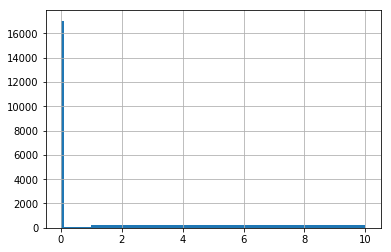

In [143]:
err.hist(bins=[0,.1,1,10])
plt.show()

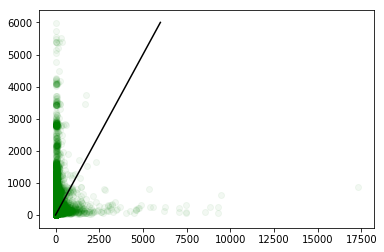

In [134]:
plt.plot([0, 6000], [0, 6000], color='black')
plt.scatter(y_test, preds, alpha=0.05, color='green')
plt.show()